In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# !pip install pyyaml==5.4.1

In [3]:
# !pip install lightautoml --user
# !pip install xgboost --user

In [3]:
# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score


PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp 
    where gggg indicates a group the passenger is travelling with and pp is their number within the group.
People in a group are often family members, but not always.
HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
CryoSleep - Indicates whether the passenger elected to be put into suspended animation 
    for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, 
    where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
Age - The age of the passenger.
VIP - Whether the passenger has paid for special VIP service during the voyage.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at 
    each of the Spaceship Titanic's many luxury amenities.
Name - The first and last names of the passenger.
Transported - Whether the passenger was transported to another dimension. 
    This is the target, the column you are trying to predict.
test.csv - Personal records for the remaining one-third (~4300) of the passengers, 
    to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

In [3]:
train_dataset = pd.read_csv('train.csv')
# making test dataset
test_dataset = pd.read_csv('test.csv') 

all_data = pd.concat([train_dataset, test_dataset], ignore_index=True)
print(train_dataset.shape, test_dataset.shape, all_data.shape)

(8693, 14) (4277, 13) (12970, 14)


E:\Programms\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [ ]:
all_data

In [199]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
Age             12700 non-null float64
Cabin           12671 non-null object
CryoSleep       12660 non-null object
Destination     12696 non-null object
FoodCourt       12681 non-null float64
HomePlanet      12682 non-null object
Name            12676 non-null object
PassengerId     12970 non-null object
RoomService     12707 non-null float64
ShoppingMall    12664 non-null float64
Spa             12686 non-null float64
Transported     8693 non-null object
VIP             12674 non-null object
VRDeck          12702 non-null float64
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


In [ ]:
# gggg_pp parse it     
    # where gggg indicates a group the passenger is travelling with and pp is their number within the group.
    # People in a group are often family members, but not always.

1. percent ofsurvavils per groupe
2. number of persons in groupe
3. check of groups simularities in train/test
4. Family groupe flag  #split Name for surname
5. 
 


In [ ]:
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, 
    where side can be either P for Port or S for Starboard.

In [76]:
train_dataset.Cabin.unique()  

array(['B/0/P', 'F/0/S', 'A/0/S', ..., 'G/1499/S', 'G/1500/S', 'E/608/S'],
      dtype=object)

# Filling NA with predictions

In [8]:
# all_data.info()

In [125]:
train_dataset = pd.read_csv('train.csv')
# making test dataset
test_dataset = pd.read_csv('test.csv') 

all_data = pd.concat([train_dataset, test_dataset], ignore_index=True)
print(train_dataset.shape, test_dataset.shape, all_data.shape)

E:\Programms\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


(8693, 14) (4277, 13) (12970, 14)


In [79]:
# Expenses
all_data['total_expenses'] = all_data[['RoomService', 'FoodCourt', 
                                                 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

all_data['RoomServicePercent'] = all_data['RoomService'] / all_data['total_expenses']
all_data['FoodCourtPercent'] = all_data['FoodCourt'] / all_data['total_expenses']
all_data['ShoppingMallPercent'] = all_data['ShoppingMall'] / all_data['total_expenses']
all_data['SpaPercent'] = all_data['Spa'] / all_data['total_expenses']
all_data['VRDeckPercent'] = all_data['VRDeck'] / all_data['total_expenses']

In [127]:
all_data['Destination'] = all_data['Destination'].fillna('None')
all_data['HomePlanet'] = all_data['HomePlanet'].fillna('None')
all_data['deck'] = all_data['HomePlanet'].fillna('None')
all_data['side'] = all_data['HomePlanet'].fillna('None')

# Spliting few columns
all_data[['deck', 'num', 'side']] = all_data.Cabin.str.split('/', 2, expand=True)
all_data[['deck', 'num', 'side']] = all_data.Cabin.str.split('/', 2, expand=True)

all_data[['p_group', 'p_num']] = all_data.PassengerId.str.split('_', 1, expand=True) 

all_data['group_members'] = all_data.groupby('p_group')['p_group'].transform('count')
all_data['ppl_in_cabin'] = all_data.groupby('num')['num'].transform('count')

all_data['no_name'] = all_data['Name'].isna()
all_data['Age'] = all_data['Age'].fillna(np.mean(all_data['Age']))
all_data['ppl_in_cabin'] = all_data['ppl_in_cabin'].fillna(np.mean(all_data['ppl_in_cabin']))

In [7]:
# all_data.info()

In [ ]:
'HomePlanet', 'CryoSleep', 'Destination', 'VIP',
# nums to predict 
'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'

# Auto predicting num values

In [6]:
# all_data.info()

In [5]:
# all_data.columns

In [131]:
%%time
ultimate_target = 'Transported'
local_target_list = ['FoodCourt', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck']
# params
N_THREADS1 = 8
N_FOLDS1 = 3
TEST_SIZE1 = 0.2

for lt in local_target_list:
    local_df = all_data[all_data[lt].notna()]
    to_predict_df = all_data[all_data[lt].isna()]    
    
    print('processing ', lt, len(to_predict_df), 'missing values')
    
    trgt = local_df[lt] #будем брать логарифм ?
    trn = local_df.drop(columns = [ultimate_target])#, 'total_expenses'])
    
    X_tr, X_te, y_tr, y_te = train_test_split(trn, trgt)# local_df, local_df[local_target]
    
#     Task
    task1 = Task('reg', metric='mse')
    roles1 = {'target': lt }
    
    automl_loc = TabularAutoML(
    task = task1
    ,cpu_limit = N_THREADS1
    ,reader_params = {'n_jobs': N_THREADS1, 'cv': N_FOLDS1}
    ,general_params = {'nested_cv': False, 'use_algos': [['lgb_tuned','cb_tuned']]}
    ,tuning_params = {'max_tuning_iter': 10})
       
#     Fitting model
    oof_pred1 = automl_loc.fit_predict(X_tr, roles = roles1, verbose = 0)
    
#     globals()['tr_pred1_%s' % lt] = automl_loc.predict(X_tr)
#     globals()['te_pred1_%s' % lt] = automl_loc.predict(X_te)
    tr_loc_pred = automl_loc.predict(X_tr)
    te_loc_pred = automl_loc.predict(X_te)
    
    print(f'OOF score: {r2_score(X_tr[lt].values, (tr_loc_pred.data[:, 0]))}')
    print(f'HOLDOUT score: {r2_score(X_te[lt].values, (te_loc_pred.data[:, 0]))}', '\n')  

    globals()['fin_pred_%s' % lt] = automl_loc.predict(to_predict_df)
    
    rep_df = pd.DataFrame(globals()["fin_pred_" + str(lt)].data[:, 0]
                          , index = all_data[all_data[lt].isna()].loc[:,[lt]].index, columns = ['pred_values'])
    
    all_data[lt].fillna(rep_df['pred_values'], inplace = True)    
    
#     exec('string%s' % lt)
#     print(f'OOF score: {r2_score(X_tr[local_target], ((f'tr_pred1_%s' % lt).data[:, 0]))}')
#     print(f'HOLDOUT score: {r2_score(X_te[local_target].values, (('te_pred1_%s' % lt).data[:, 0]))}')   
            
#     print(f'OOF score: {r2_score(X_tr[local_target], (['tr_pred1_%s' % lt].data[:, 0]))}')
#     print(f'HOLDOUT score: {r2_score(X_te[local_target].values, (['te_pred1_%s' % lt].data[:, 0]))}') 

processing  FoodCourt 289 missing values
OOF score: 0.5315819205398861
HOLDOUT score: 0.4022835418054559 

processing  RoomService 263 missing values
OOF score: 0.44943181113883157
HOLDOUT score: 0.35563564817075954 

processing  ShoppingMall 306 missing values
OOF score: 0.4190978029123772
HOLDOUT score: 0.1440994356933779 

processing  Spa 284 missing values
OOF score: 0.5343873634818745
HOLDOUT score: 0.22947909081896034 

processing  VRDeck 268 missing values
OOF score: 0.4526512857544982
HOLDOUT score: 0.2901576791172491 

Wall time: 7min 4s


In [132]:
# Expenses
all_data['total_expenses'] = all_data[['RoomService', 'FoodCourt', 
                                                 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

all_data['RoomServicePercent'] = all_data['RoomService'] / all_data['total_expenses']
all_data['FoodCourtPercent'] = all_data['FoodCourt'] / all_data['total_expenses']
all_data['ShoppingMallPercent'] = all_data['ShoppingMall'] / all_data['total_expenses']
all_data['SpaPercent'] = all_data['Spa'] / all_data['total_expenses']
all_data['VRDeckPercent'] = all_data['VRDeck'] / all_data['total_expenses']

# Start

In [4]:
train_dataset = pd.read_csv('train.csv')
# making test dataset
test_dataset = pd.read_csv('test.csv') 

all_data = pd.concat([train_dataset, test_dataset], ignore_index=True)
print(train_dataset.shape, test_dataset.shape, all_data.shape)

(8693, 14) (4277, 13) (12970, 14)


In [5]:
# filling with mean spendings by vip-status
all_data['VRDeck'] = all_data['VRDeck'].fillna(all_data.groupby('VIP')['VRDeck'].transform('mean'))
all_data['RoomService'] = all_data['RoomService'].fillna(all_data.groupby('VIP')['RoomService'].transform('mean'))
all_data['ShoppingMall'] = all_data['ShoppingMall'].fillna(all_data.groupby('VIP')['ShoppingMall'].transform('mean'))
all_data['Spa'] = all_data['Spa'].fillna(all_data.groupby('VIP')['Spa'].transform('mean'))
all_data['FoodCourt'] = all_data['FoodCourt'].fillna(all_data.groupby('VIP')['FoodCourt'].transform('mean'))

In [6]:
# all_data.info() 

In [7]:
# Expenses
all_data['total_expenses'] = all_data[['RoomService', 'FoodCourt', 
                                                 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

all_data['RoomServicePercent'] = all_data['RoomService'] / all_data['total_expenses']
all_data['FoodCourtPercent'] = all_data['FoodCourt'] / all_data['total_expenses']
all_data['ShoppingMallPercent'] = all_data['ShoppingMall'] / all_data['total_expenses']
all_data['SpaPercent'] = all_data['Spa'] / all_data['total_expenses']
all_data['VRDeckPercent'] = all_data['VRDeck'] / all_data['total_expenses']


all_data[['RoomServicePercent', 'FoodCourtPercent', 'ShoppingMallPercent','SpaPercent'
         , 'VRDeckPercent']] = all_data[['RoomServicePercent', 'FoodCourtPercent', 
                            'ShoppingMallPercent','SpaPercent', 'VRDeckPercent']].fillna(0)

all_data['Destination'] = all_data['Destination'].fillna('None')
# 

In [8]:
# all_data['families_inCab'].value_counts()

In [9]:
all_data[['p_name', 'surname']] = all_data.Name.str.split(' ', 1, expand=True)

all_data['families_inCab'] = all_data.groupby('Cabin')['surname'].apply(lambda x: x.unique())
# all_data['families_inCab'] = all_data.groupby('Cabin')['surname'].transform('unique')
all_data['families_inCab'] = all_data.families_inCab.str.len().fillna(1)

In [10]:
# filling NA for Familys and VIP, HomePlanet
for i in range(0, len(all_data)):
    if all_data.loc[i, ['Cabin']].isna().any() == True:
        if all_data.loc[i, ['surname']].any() == all_data.loc[i + 1, ['surname']].any():    
            all_data.loc[i, ['Cabin']] = all_data.loc[i, ['Cabin']].fillna(all_data.loc[i + 1, ['Cabin']])
            
        elif all_data.loc[i, ['surname']].any() == all_data.loc[i -1, ['surname']].any():
            all_data.loc[i, ['Cabin']] = all_data.loc[i, ['Cabin']].fillna(all_data.loc[i -1, ['Cabin']])
            
for i in range(0, len(all_data)):
    if all_data.loc[i, ['VIP']].isna().any() == True:
        if all_data.loc[i, ['surname']].any() == all_data.loc[i + 1, ['surname']].any():    
            all_data.loc[i, ['VIP']] = all_data.loc[i, ['VIP']].fillna(all_data.loc[i + 1, ['VIP']])
            
        elif all_data.loc[i, ['surname']].any() == all_data.loc[i -1, ['surname']].any():
            all_data.loc[i, ['VIP']] = all_data.loc[i, ['VIP']].fillna(all_data.loc[i -1, ['VIP']])   

for i in range(0, len(all_data)):
    if all_data.loc[i, ['HomePlanet']].isna().any() == True:
        if all_data.loc[i, ['surname']].any() == all_data.loc[i + 1, ['surname']].any():    
            all_data.loc[i, ['HomePlanet']] = all_data.loc[i, ['HomePlanet']].fillna(all_data.loc[i + 1, ['HomePlanet']])
            
        elif all_data.loc[i, ['surname']].any() == all_data.loc[i -1, ['surname']].any():
            all_data.loc[i, ['HomePlanet']] = all_data.loc[i, ['HomePlanet']].fillna(all_data.loc[i -1, ['HomePlanet']])             

In [11]:
# all_data.info()

In [12]:
# Spliting few columns
all_data[['deck', 'num', 'side']] = all_data.Cabin.str.split('/', 2, expand=True)
all_data[['deck', 'num', 'side']] = all_data.Cabin.str.split('/', 2, expand=True)

all_data['deck'] = all_data['deck'].fillna('None')
all_data['side'] = all_data['side'].fillna('None')

all_data[['p_group', 'p_num']] = all_data.PassengerId.str.split('_', 1, expand=True) 

# all_data['families_inCab'] = all_data.groupby('Cabin')['surname'].apply(lambda x: x.unique())


all_data['group_members'] = all_data.groupby('p_group')['PassengerId'].transform('nunique')
all_data['ppl_in_cabin'] = all_data.groupby('Cabin')['PassengerId'].transform('nunique')

all_data['no_name'] = all_data['Name'].isna()

In [13]:
all_data['Age'] = all_data['Age'].fillna(np.mean(all_data['Age']))
all_data['ppl_in_cabin'] = all_data['ppl_in_cabin'].fillna(np.mean(all_data['ppl_in_cabin']))

temp_df = all_data[(all_data.VIP.isna()) & (all_data.total_expenses >= 4690)][['VIP']].fillna(True)
all_data['VIP'].fillna(temp_df['VIP'], inplace = True)    
all_data['VIP'].fillna(False, inplace = True)  

In [14]:
# filling with mean spendings by vip-status again
all_data['VRDeck'] = all_data['VRDeck'].fillna(all_data.groupby('VIP')['VRDeck'].transform('mean'))
all_data['RoomService'] = all_data['RoomService'].fillna(all_data.groupby('VIP')['RoomService'].transform('mean'))
all_data['ShoppingMall'] = all_data['ShoppingMall'].fillna(all_data.groupby('VIP')['ShoppingMall'].transform('mean'))
all_data['Spa'] = all_data['Spa'].fillna(all_data.groupby('VIP')['Spa'].transform('mean'))
all_data['FoodCourt'] = all_data['FoodCourt'].fillna(all_data.groupby('VIP')['FoodCourt'].transform('mean'))

# Expenses again
all_data['total_expenses'] = all_data[['RoomService', 'FoodCourt', 
                                                 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

all_data['RoomServicePercent'] = all_data['RoomService'] / all_data['total_expenses']
all_data['FoodCourtPercent'] = all_data['FoodCourt'] / all_data['total_expenses']
all_data['ShoppingMallPercent'] = all_data['ShoppingMall'] / all_data['total_expenses']
all_data['SpaPercent'] = all_data['Spa'] / all_data['total_expenses']
all_data['VRDeckPercent'] = all_data['VRDeck'] / all_data['total_expenses']


all_data[['RoomServicePercent', 'FoodCourtPercent', 'ShoppingMallPercent','SpaPercent'
         , 'VRDeckPercent']] = all_data[['RoomServicePercent', 'FoodCourtPercent', 
                            'ShoppingMallPercent','SpaPercent', 'VRDeckPercent']].fillna(0)
all_data['HomePlanet'] = all_data['HomePlanet'].fillna('None')

In [15]:
# all_data.loc[12947:12952, ['Name', 'HomePlanet', 'Age', 'Cabin', 'CryoSleep', 'Destination', 'Transported']]

In [16]:
# # Just mean for those how didn't has VIP-stat value
# all_data[['total_expenses','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomServicePercent',
#               'FoodCourtPercent', 'ShoppingMallPercent', 'SpaPercent','VRDeckPercent']] = all_data[[
#     'total_expenses','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomServicePercent',
#               'FoodCourtPercent', 'ShoppingMallPercent', 'SpaPercent','VRDeckPercent']].fillna(
#     all_data[['total_expenses','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomServicePercent',
#               'FoodCourtPercent', 'ShoppingMallPercent', 'SpaPercent','VRDeckPercent']].mean())

In [17]:
all_data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'total_expenses', 'RoomServicePercent',
       'FoodCourtPercent', 'ShoppingMallPercent', 'SpaPercent',
       'VRDeckPercent', 'p_name', 'surname', 'families_inCab', 'deck', 'num',
       'side', 'p_group', 'p_num', 'group_members', 'ppl_in_cabin', 'no_name'],
      dtype='object')

In [18]:
to_drop = ['Cabin','Name', 'p_name', 'surname', 'PassengerId', 'p_group']
# 'p_num'
categ_features = ['Destination', 'HomePlanet', 'deck', 'side']

In [19]:
all_data[categ_features] = all_data[categ_features].astype(str)
all_data = all_data.drop(to_drop, axis = 1)

In [20]:
# getting dummies
all_dummis = pd.get_dummies(all_data[categ_features], drop_first = True)

## Memory reduction

In [21]:
for col in all_data.columns:
    if all_data[col].dtype=='float64': all_data[col] = all_data[col].astype('float32')
    if all_data[col].dtype=='int64': all_data[col] = all_data[col].astype('int32')

In [22]:
all_data[col],_ = all_data[col].factorize()
for i in all_data.columns:
    if all_data[col].max()<128: all_data[col] = all_data[col].astype('int8')
    elif all_data[col].max()<32768: all_data[col] = all_data[col].astype('int16')
    else: all_data[col].astype('int32')

In [23]:
train_df = all_data[all_data['Transported'].notna()]

le = LabelEncoder()
train_df['Transported']= le.fit_transform(train_df['Transported'])

test_df = all_data[all_data['Transported'].isna()]
print(train_df.shape, test_df.shape)

(8693, 25) (4277, 25)


C:\Users\admin\AppData\Local\Temp\ipykernel_15300\1345896546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Transported']= le.fit_transform(train_df['Transported'])


In [82]:
from sklearn.model_selection import train_test_split, ShuffleSplit
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import PolynomialFeatures

# Sequantial ANN

In [219]:
# !pip install update tensorflow-gpu --user
!pip install update livelossplot --user

In [24]:
import tensorflow as tf

In [25]:
print(tf.__version__)

2.10.1


In [26]:
# train_df.columns
all_dummis.tail()

In [29]:
# all_data1.tail()

In [28]:
all_data1 = all_data.drop(columns = categ_features)
all_data1 = pd.concat([all_data1,all_dummis], axis = 1)

In [106]:
# all_data1.tail()

In [30]:
categ_features = ['Destination', 'HomePlanet', 'deck', 'side']

In [31]:
train_df = all_data1[all_data1['Transported'].notna()]

le = LabelEncoder()
train_df['Transported']= le.fit_transform(train_df['Transported'])

test_df = all_data1[all_data1['Transported'].isna()]
print(train_df.shape, test_df.shape)

(8693, 37) (4277, 37)


C:\Users\admin\AppData\Local\Temp\ipykernel_15300\3462287161.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Transported']= le.fit_transform(train_df['Transported'])


In [34]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['Transported'], axis = 1)
                                                    , train_df['Transported']#.astype(bool)
#                                                     , shuffle= True
#                                                     , stratify=train_df[TARGET_NAME]
                                                   )

In [172]:
ddd = np.random.random((1000, 784))
# ddd[0]

In [35]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
mns = MinMaxScaler()

In [36]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(type(X_train))
# X_train = mns.fit_transform(X_train)
# X_test = mns.transform(X_test)


# X_train = np.array(X_train)
# X_test = np.array(X_test)
print(type(X_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [121]:
X_train.shape

(6519, 36)

In [104]:
X_train[0]

array([-0.7380551 , -1.45585678, -0.15554683, -0.3397921 , -0.2920991 ,
       -0.27796367, -0.27668855, -0.26758427, -0.52676454, -0.48197145,
       -0.49152957, -0.44182974, -0.46159299, -0.45198666,  0.        ,
       -0.11823819,  2.36350327,  1.21977777,  0.82676536, -0.15554683,
       -0.15241477, -0.31779939,  0.690089  , -0.58425853,  1.96317551,
       -0.03505267, -0.32158839, -0.3157473 , -0.24705294, -0.33647766,
        1.43047603, -0.64923048, -0.02477837, -0.02477837,  1.00692689,
       -1.00569192])

In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, ReLU, LeakyReLU, Input
from livelossplot import PlotLossesKeras

In [147]:
clf = Sequential()

In [148]:
# clf.add(Input(shape = (36,)))
# clf.add(Dense(units = 36, activation= 'relu'))
clf.add(Dense(units = 36, activation= 'tanh'
              # , input_shape = (,)
             ))
clf.add(Dense(units = 50, activation= 'tanh'))
clf.add(Dense(units = 1, activation= 'sigmoid'))
clf.build((None, 36))

In [184]:
clf = Sequential()
# clf.add(Dense(units = 36, activation= 'relu'))
clf.add(Dense(36, activation= 'tanh'
              # , input_dim=36
             ))
clf.add(Dense(10, activation= 'tanh'))
clf.add(Dense(1, activation= 'sigmoid'))
# clf.build((None, 36))

In [185]:
clf.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# clf.layers

In [186]:
# clf.weights

In [187]:
# print(y_train.shape, X_train.shape)

In [192]:
model_hist = clf.fit(X_train, y_train, epochs=10
                     , batch_size = 1
                    ,validation_data=(X_test, y_test)
                     # ,inp
                     # , callbacks=[PlotLossesKeras()]
                    )

Epoch 1/10
6519/6519 [==============================] - 23s 4ms/step - loss: nan - accuracy: 0.4990 - val_loss: nan - val_accuracy: 0.4885
Epoch 2/10
6519/6519 [==============================] - 18s 3ms/step - loss: nan - accuracy: 0.4990 - val_loss: nan - val_accuracy: 0.4885
Epoch 3/10
6519/6519 [==============================] - 15s 2ms/step - loss: nan - accuracy: 0.4990 - val_loss: nan - val_accuracy: 0.4885
Epoch 4/10
6519/6519 [==============================] - 15s 2ms/step - loss: nan - accuracy: 0.4990 - val_loss: nan - val_accuracy: 0.4885
Epoch 5/10
6519/6519 [==============================] - 15s 2ms/step - loss: nan - accuracy: 0.4990 - val_loss: nan - val_accuracy: 0.4885
Epoch 6/10
6519/6519 [==============================] - 15s 2ms/step - loss: nan - accuracy: 0.4990 - val_loss: nan - val_accuracy: 0.4885
Epoch 7/10
6519/6519 [==============================] - 15s 2ms/step - loss: nan - accuracy: 0.4990 - val_loss: nan - val_accuracy: 0.4885
Epoch 8/10
6519/6519 [=====

In [156]:
score = clf.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: nan
Test accuracy: 0.4885004460811615


In [157]:
clf.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 36)                1332      
                                                                 
 dense_68 (Dense)            (None, 50)                1850      
                                                                 
 dense_69 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,233
Trainable params: 3,233
Non-trainable params: 0
_________________________________________________________________


In [120]:
clf.weights

[<tf.Variable 'dense_46/kernel:0' shape=(36, 40) dtype=float32, numpy=
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)>,
 <tf.Variable 'dense_46/bias:0' shape=(40,) dtype=float32, numpy=
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan], dtype=float32)>,
 <tf.Variable 'dense_47/kernel:0' shape=(40, 50) dtype=float32, numpy=
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
   

In [233]:
y_train.sum()

3264

In [74]:
task = Task('binary', metric='accuracy')
roles = {'target': TARGET_NAME,
#     'drop': ['SK_ID_CURR']
}

In [75]:
automl = TabularAutoML(
    task = task
#     ,timeout = TIMEOUT
    ,cpu_limit = N_THREADS
    ,reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS}
    ,general_params = {'nested_cv': False, 'use_algos': [['lgb_tuned','cb_tuned']]}
    ,tuning_params = {'max_tuning_iter': 50},
)

In [76]:
# X_train.columns.tolist()

In [77]:
%%time
oof_pred = automl.fit_predict(X_train, roles = roles, verbose = 0)
tr_pred = automl.predict(X_train)
te_pred = automl.predict(X_test)
print(f'OOF score: {accuracy_score(X_train[TARGET_NAME], (oof_pred.data[:, 0] >= 0.5).astype(bool))}')
print(f'HOLDOUT score: {accuracy_score(X_test[TARGET_NAME].values, (te_pred.data[:, 0] >= 0.5).astype(bool))}')

OOF score: 0.8082527995091272
HOLDOUT score: 0.8054277828886844
Wall time: 4min 25s


In [78]:
tr_pred = automl.predict(X_train)
te_pred = automl.predict(X_test)
print(f'OOF score: {accuracy_score(X_train[TARGET_NAME], (tr_pred.data[:, 0] > 0.5).astype(bool))}')
print(f'HOLDOUT score: {accuracy_score(X_test[TARGET_NAME].values, (te_pred.data[:, 0] > 0.5).astype(bool))}')

OOF score: 0.8373983739837398
HOLDOUT score: 0.8054277828886844


In [79]:
print(automl.create_model_str_desc())
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task,
#         timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS}
    )
)

Final prediction for new objects (level 0) = 
	 0.56679 * (5 averaged models Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM) +
	 0.43321 * (5 averaged models Lvl_0_Pipe_0_Mod_1_Tuned_CatBoost) 


In [80]:
# !ls tabularAutoML_model_report

Wall time: 71.4 ms


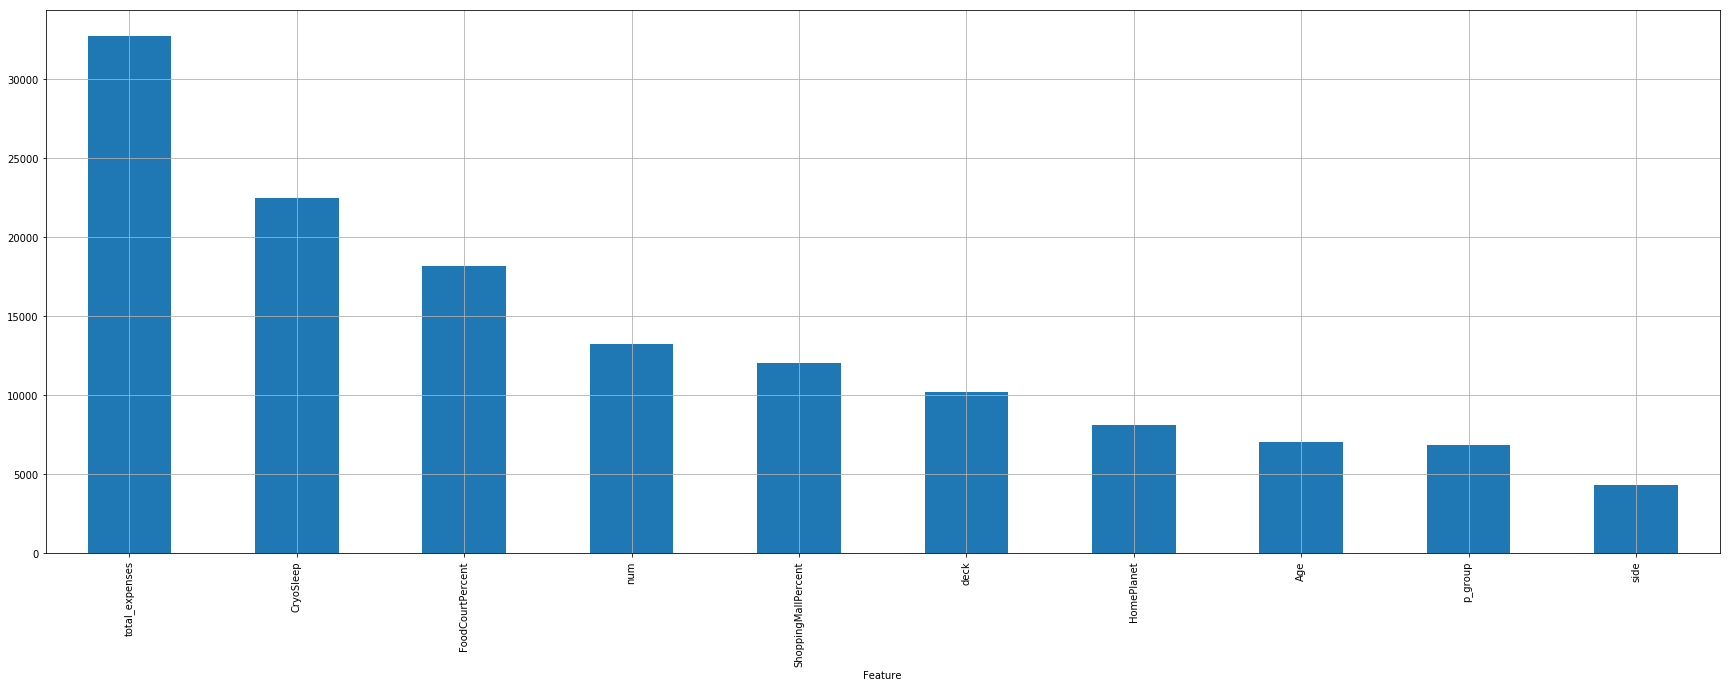

In [81]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].head(10).plot.bar(figsize = (30, 10), grid = True)

In [82]:
fast_fi = pd.DataFrame(automl.get_feature_scores('fast'))
fast_fi.set_index('Feature')['Importance'].head(10)

Feature
total_expenses         32749.546021
CryoSleep              22469.841654
FoodCourtPercent       18193.782694
num                    13257.856878
ShoppingMallPercent    12042.293506
deck                   10187.836848
HomePlanet              8111.640551
Age                     7078.910460
p_group                 6887.301500
side                    4327.167619
Name: Importance, dtype: float64

In [83]:
lama1_fin_pred = (automl.predict(test_df).data[:,0] >= 0.5).astype(bool)
lama1_fin_pred = test_dataset[['PassengerId']].join(pd.DataFrame(lama1_fin_pred, columns = ['Transported']))

In [84]:
pd.DataFrame(lama1_fin_pred).to_csv('sample_submission_lama1.csv', index = False)

In [27]:
print(cat_model.get_best_iteration())

None


In [108]:
test_df.columns

Index(['Age', 'Cabin', 'CryoSleep', 'Destination', 'FoodCourt', 'HomePlanet',
       'Name', 'PassengerId', 'RoomService', 'ShoppingMall', 'Spa',
       'Transported', 'VIP', 'VRDeck', 'deck', 'side', 'num', 'p_group',
       'p_num', 'group_members', 'ppl_in_cabin', 'no_name'],
      dtype='object')

In [56]:
fin_pred1 = cat_model.predict(test_df.drop(columns = ['Transported'])) 

In [57]:
fin_pred1 = test_dataset[['PassengerId']].join(pd.DataFrame(fin_pred1, columns = ['Transported']))
fin_pred1.to_csv('sample_submission.csv', index = False)

# fin_pred1 0.803 Score in Kaggle


# Adding polynomes

In [94]:
train_df = all_data[all_data['Transported'].notna()]

le = LabelEncoder()
train_df[['Transported']]= le.fit_transform(train_df['Transported'])

test_df = all_data[all_data['Transported'].isna()]

train_df = train_df.drop(['p_name', 'surname', 'Name'], axis = 1)
test_df = test_df.drop(['p_name', 'surname', 'Name'], axis = 1)

print(train_df.shape, test_df.shape)

E:\Programms\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
E:\Programms\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(8693, 28) (4277, 28)


In [96]:
# all_data.info()

In [97]:
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['Transported'], axis = 1)
                                                    , train_df.Transported, shuffle= True)

num_cols = train_df.drop(['Transported'], axis = 1).columns[X_train.dtypes != object].tolist()
# X_train[num_cols].info()

In [98]:
X_train_polyed = pd.DataFrame(poly.fit_transform(X_train[num_cols]))
X_test_polyed = pd.DataFrame(poly.fit_transform(X_test[num_cols]))

# X_train = X_train.drop(columns = num_cols)#.reset_index(drop = True)
# X_test = X_test.drop(columns = num_cols)#.reset_index(drop = True)

In [99]:
X_train_polyed.shape

(6519, 170)

In [101]:
# X_test.columns.tolist()
# X_test[categ_features].info()

In [103]:
train_dataset = Pool(data = X_train.drop(columns = ['Cabin','PassengerId']),
                     label = y_train.astype(bool),
                     cat_features=categ_features)

eval_dataset = Pool(data = X_test.drop(columns = ['Cabin', 'PassengerId']),
                     label = y_test.astype(bool),
                    cat_features=categ_features)

In [104]:
cat_model2 = CatBoostClassifier(verbose = 1, eval_metric='Accuracy', iterations = 15000)

In [105]:
%%time
cat_model2.fit(train_dataset)

Learning rate set to 0.001915
0:	learn: 0.7768063	total: 66.8ms	remaining: 16m 41s
1:	learn: 0.7936800	total: 118ms	remaining: 14m 45s
2:	learn: 0.7975150	total: 172ms	remaining: 14m 19s
3:	learn: 0.7952140	total: 226ms	remaining: 14m 6s
4:	learn: 0.7955208	total: 278ms	remaining: 13m 53s
5:	learn: 0.7953674	total: 334ms	remaining: 13m 54s
6:	learn: 0.7946004	total: 384ms	remaining: 13m 43s
7:	learn: 0.7952140	total: 428ms	remaining: 13m 22s
8:	learn: 0.7958276	total: 472ms	remaining: 13m 6s
9:	learn: 0.7961344	total: 520ms	remaining: 12m 58s
10:	learn: 0.7964412	total: 564ms	remaining: 12m 48s
11:	learn: 0.7964412	total: 612ms	remaining: 12m 44s
12:	learn: 0.7956742	total: 669ms	remaining: 12m 50s
13:	learn: 0.7952140	total: 728ms	remaining: 12m 59s
14:	learn: 0.7975150	total: 789ms	remaining: 13m 8s
15:	learn: 0.7981285	total: 847ms	remaining: 13m 12s
16:	learn: 0.7982819	total: 892ms	remaining: 13m 5s
17:	learn: 0.7985887	total: 937ms	remaining: 12m 59s
18:	learn: 0.7972082	total: 9

In [106]:
print(cat_model2.get_best_iteration())

None


In [196]:
dd = {'feat': X_train.drop(columns = ['Cabin',  'PassengerId']).columns
      , 'rate': cat_model2.get_feature_importance()}
pd.DataFrame(dd).sort_values(['rate'], ascending = False).head(10)
#     dict('feat': X_train.columns, 'rate': cat_model.get_feature_importance()))

feat       rate
10    total_expenses  13.798281
4         HomePlanet   9.206157
19               num   8.899330
16              deck   8.235001
1          CryoSleep   7.197288
12  FoodCourtPercent   6.974692
17              side   5.095232
0                Age   4.855560
20           p_group   4.074195
7                Spa   3.815472

In [110]:
train_preds = cat_model2.predict(X_train.drop(columns = ['Cabin',  'PassengerId']))
test_preds = cat_model2.predict(X_test.drop(columns = ['Cabin', 'PassengerId']))

In [111]:
train_preds

array(['True', 'True', 'True', ..., 'True', 'False', 'False'],
      dtype=object)

In [112]:
print('Правильность на обучающем наборе: {:.3f}'.format(accuracy_score(train_preds.astype(bool), y_train.astype(bool))))
print('Правильность на обучающем наборе: {:.3f}'.format(accuracy_score(test_preds.astype(bool), y_test.astype(bool))))#.astype(bool)

Правильность на обучающем наборе: 0.508
Правильность на обучающем наборе: 0.491


In [717]:
# Basic catboost
# Правильность на обучающем наборе: 0.863
# Правильность на обучающем наборе: 0.812

SyntaxError: invalid syntax (<ipython-input-717-4f27e826db72>, line 1)

In [113]:
test_df_polyed = pd.DataFrame(poly.fit_transform(test_df[num_cols]))
test_df1 = test_df.join(test_df_polyed).drop(['Transported'], axis = 1)

In [115]:
fin_pred2 = cat_model2.predict(test_df1.drop(columns = ['Cabin',  'PassengerId']))
fin_pred2 = test_dataset[['PassengerId']].join(pd.DataFrame(fin_pred2, columns = ['Transported']))
fin_pred2.to_csv('sample_submission2.csv', index = False)
# тот же результат

# Lama and poly

In [255]:
# all_data.info()

In [692]:
train_df = all_data[all_data['Transported'].notna()]

le = LabelEncoder()
train_df[['Transported']]= le.fit_transform(train_df['Transported'])

test_df = all_data[all_data['Transported'].isna()]




print(train_df.shape, test_df.shape)

E:\Programms\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
E:\Programms\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(8693, 28) (4277, 28)


In [694]:
poly = PolynomialFeatures(degree=2, include_bias = False, interaction_only = True)

X_train, X_test, y_train, y_test = train_test_split(train_df
                                                    #.drop(['Transported'], axis = 1)
                                                    , train_df.Transported.astype(bool), shuffle= True)

num_cols = train_df.columns[X_train.dtypes != object].tolist()
cl = list()
for i in range(136):
    cl.append('col_%s' %i)

X_train_polyed = pd.DataFrame(poly.fit_transform(X_train[num_cols].drop(['Transported'], axis = 1)), columns = cl)
X_test_polyed = pd.DataFrame(poly.fit_transform(X_test[num_cols].drop(['Transported'], axis = 1)), columns = cl)
X_train = X_train.join(X_train_polyed)
X_test = X_test.join(X_test_polyed)


In [695]:
N_THREADS = 7
N_FOLDS = 5
# RANDOM_STATE = 42
TEST_SIZE = 0.2
# TIMEOUT = 300
TARGET_NAME = 'Transported'

In [696]:
# X_train, X_test, y_train, y_test = train_test_split(train_df
#                                                     , train_df[TARGET_NAME].astype(bool)
# #                                                     , shuffle= True
# #                                                     , stratify=train_df[TARGET_NAME]
#                                                    )

In [697]:
task = Task('binary', metric='accuracy')
roles = {'target': TARGET_NAME,
#     'drop': ['SK_ID_CURR']
}
automl = TabularAutoML(
    task = task
#     ,timeout = TIMEOUT
    ,cpu_limit = N_THREADS
    ,reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS}
    ,general_params = {'nested_cv': False, 'use_algos': [['cb_tuned']]
#                       [['lgb','lgb_tuned','cb', 'cb_tuned']]
                      }
    ,tuning_params = {'max_tuning_iter': 500},
)

In [698]:
# X_train.info()

In [699]:
%%time
oof_pred = automl.fit_predict(X_train, roles = roles, verbose = 1)
tr_pred = automl.predict(X_train)
te_pred = automl.predict(X_test)
print(f'OOF score: {accuracy_score(X_train[TARGET_NAME], (oof_pred.data[:, 0] >= 0.5).astype(bool))}')
print(f'HOLDOUT score: {accuracy_score(X_test[TARGET_NAME].values, (te_pred.data[:, 0] >= 0.5).astype(bool))}')

[01:42:40] Stdout logging level is INFO.
[01:42:40] Task: binary

[01:42:40] Start automl preset with listed constraints:
[01:42:40] - time: 3600.00 seconds
[01:42:40] - CPU: 7 cores
[01:42:40] - memory: 16 GB

[01:42:40] Train data shape: (6519, 164)

[01:42:52] Layer 1 train process start. Time left 3588.44 secs
[01:43:03] Selector_LightGBM fitting and predicting completed
[01:43:04] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_CatBoost ... Time budget is 300.00 secs
[01:48:05] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_CatBoost completed
[01:48:05] Start fitting Lvl_0_Pipe_0_Mod_0_Tuned_CatBoost ...
[01:48:16] Fitting Lvl_0_Pipe_0_Mod_0_Tuned_CatBoost finished. score = 0.804264457738917
[01:48:16] Lvl_0_Pipe_0_Mod_0_Tuned_CatBoost fitting and predicting completed
[01:48:16] Time left 3264.76 secs

[01:48:16] Layer 1 training completed.

[01:48:16] Automl preset training completed in 335.25 seconds

[01:48:16] Model description:
Final prediction for 

In [703]:
tr_pred = automl.predict(X_train)
te_pred = automl.predict(X_test)
print(f'OOF score: {accuracy_score(X_train[TARGET_NAME], (tr_pred.data[:, 0] > 0.5).astype(bool))}')
print(f'HOLDOUT score: {accuracy_score(X_test[TARGET_NAME].values, (te_pred.data[:, 0] > 0.5).astype(bool))}')

OOF score: 0.8131615278416935
HOLDOUT score: 0.796228150873965


In [ ]:
# X_train_polyed = pd.DataFrame(poly.fit_transform(X_train[num_cols].drop(['Transported'], axis = 1)), columns = cl)
# X_test_polyed = pd.DataFrame(poly.fit_transform(X_test[num_cols].drop(['Transported'], axis = 1)), columns = cl)
# X_train = X_train.join(X_train_polyed)
# X_test = X_test.join(X_test_polyed)

In [394]:
X_test.columns

Index(['Age', 'Cabin', 'CryoSleep', 'Destination', 'FoodCourt', 'HomePlanet',
       'Name', 'PassengerId', 'RoomService', 'ShoppingMall',
       ...
       'col_110', 'col_111', 'col_112', 'col_113', 'col_114', 'col_115',
       'col_116', 'col_117', 'col_118', 'col_119'],
      dtype='object', length=148)

In [406]:
(fin_pred2.data[:, 0] > 0.5).astype(bool)

array([ True, False,  True, ...,  True,  True,  True])

In [701]:
test_df_polyed = pd.DataFrame(poly.fit_transform(test_df[num_cols].drop(['Transported'], axis = 1)), columns = cl)
test_df1 = test_df.join(test_df_polyed)#.drop(['Transported'], axis = 1)

In [702]:
fin_pred2 = automl.predict(test_df1)#.drop(columns = ['Cabin', 'Name', 'PassengerId']))
fin_pred2 = test_dataset[['PassengerId']].join(pd.DataFrame((fin_pred2.data[:, 0] > 0.5).astype(bool)
                                                            , columns = ['Transported']))
fin_pred2.to_csv('sample_submission_lama_poly.csv', index = False)
# тот же результат

In [409]:
# fin_pred2

Wall time: 208 ms


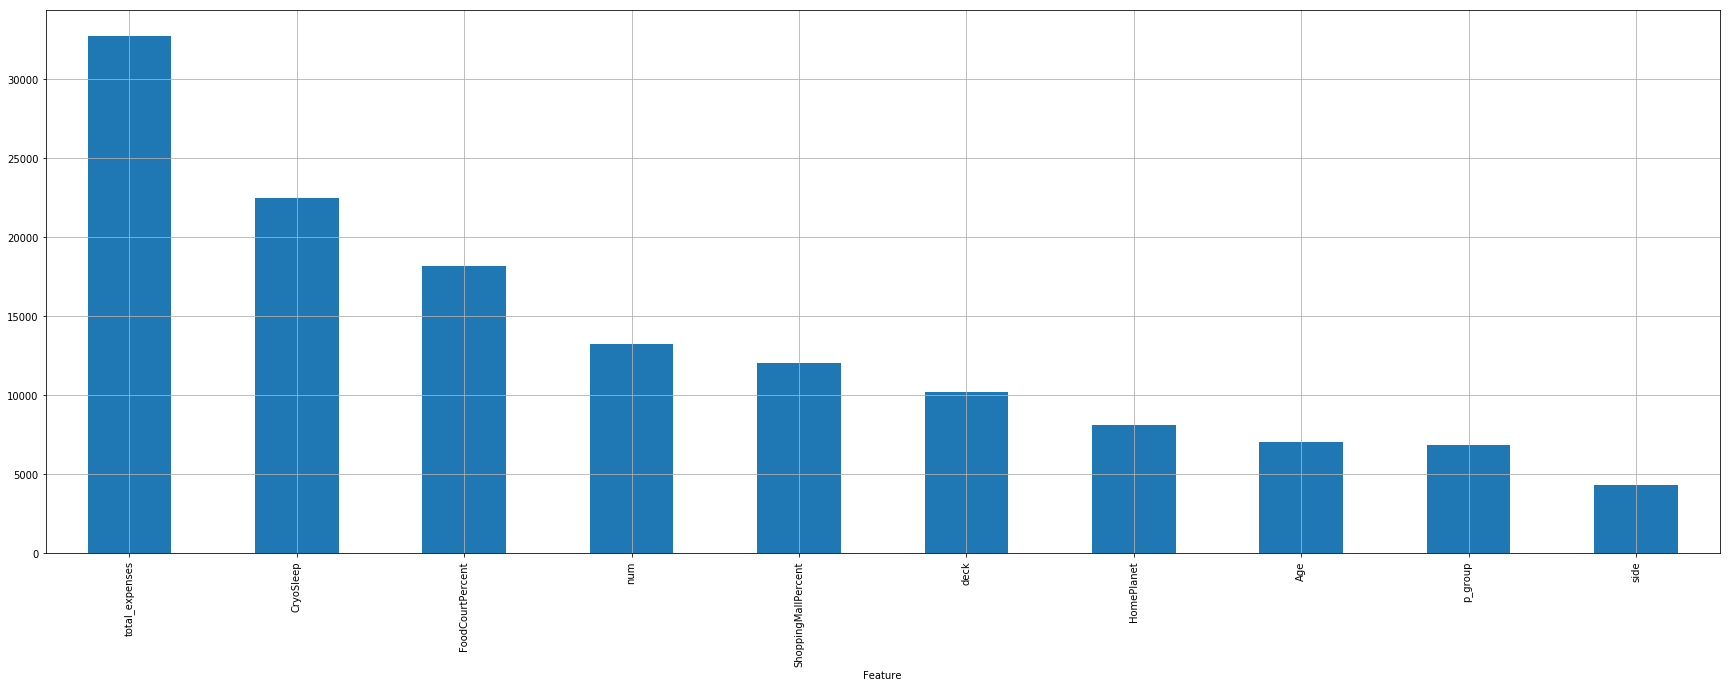

In [193]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].head(10).plot.bar(figsize = (30, 10), grid = True)

In [194]:
dd1 = {'feat': test_df1.drop(columns = ['Cabin',  'PassengerId']).columns
      , 'rate': automl.get_feature_importance()}
pd.DataFrame(dd1).sort_values(['rate'], ascending = False).head(10)
#     dict('feat': X_train.columns, 'rate': cat_model.get_feature_importance()))

AttributeError: 'TabularAutoML' object has no attribute 'get_feature_importance'

# Stacking

In [387]:
train_df = all_data[all_data['Transported'].notna()]

le = LabelEncoder()
train_df[['Transported']]= le.fit_transform(train_df['Transported'])

test_df = all_data[all_data['Transported'].isna()]

train_df = train_df.drop(['p_name', 'surname', 'Name'], axis = 1)
test_df = test_df.drop(['p_name', 'surname', 'Name'], axis = 1)

print(train_df.shape, test_df.shape)

E:\Programms\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
E:\Programms\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(8693, 28) (4277, 28)


In [182]:
# cat_model2 = CatBoostClassifier(verbose = 1, eval_metric='Accuracy', iterations = 15000)

In [388]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [397]:
estimators = [
#      ('rf', RandomForestClassifier(n_estimators=1000, random_state=42)),
#      ('svr', make_pipeline(StandardScaler(),
#                            LinearSVC(random_state=42))),
    ('cat', CatBoostClassifier(verbose = 1, eval_metric='Accuracy', iterations = 15000,
                               cat_features=categ_features))
 ]
clf = StackingClassifier(estimators=estimators, 
                         final_estimator=CatBoostClassifier(verbose = 1, eval_metric='Accuracy', iterations = 15000,
#                                cat_features=categ_features
                                                           ))

In [398]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['Transported', 'Cabin', 'PassengerId'], axis = 1)
                                                    , train_df.Transported.astype(bool), shuffle= True)

In [399]:
%%time
clf.fit(X_train, y_train)#.score(X_test, y_test) #0.88763 0stage

Learning rate set to 0.001915
0:	learn: 0.7777266	total: 73.7ms	remaining: 18m 25s
1:	learn: 0.7916858	total: 137ms	remaining: 17m 4s
2:	learn: 0.7946004	total: 187ms	remaining: 15m 33s
3:	learn: 0.7946004	total: 237ms	remaining: 14m 46s
4:	learn: 0.7953674	total: 287ms	remaining: 14m 21s
5:	learn: 0.7936800	total: 335ms	remaining: 13m 56s
6:	learn: 0.7965946	total: 390ms	remaining: 13m 56s
7:	learn: 0.7946004	total: 430ms	remaining: 13m 25s
8:	learn: 0.7947538	total: 472ms	remaining: 13m 6s
9:	learn: 0.7942936	total: 524ms	remaining: 13m 6s
10:	learn: 0.7936800	total: 576ms	remaining: 13m 4s
11:	learn: 0.7933732	total: 623ms	remaining: 12m 58s
12:	learn: 0.7941402	total: 673ms	remaining: 12m 56s
13:	learn: 0.7941402	total: 720ms	remaining: 12m 50s
14:	learn: 0.7933732	total: 766ms	remaining: 12m 45s
15:	learn: 0.7929130	total: 822ms	remaining: 12m 50s
16:	learn: 0.7927596	total: 867ms	remaining: 12m 44s
17:	learn: 0.7887713	total: 912ms	remaining: 12m 38s
18:	learn: 0.7884645	total: 9

StackingClassifier(estimators=[('cat',
                                <catboost.core.CatBoostClassifier object at 0x000001EC304D0C88>)],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x000001EC304D05F8>)

In [400]:
train_preds = clf.predict(X_train)#.drop(columns = ['Transported', 'Cabin', 'PassengerId']))
test_preds = clf.predict(X_test)#.drop(columns = ['Transported', 'Cabin', 'PassengerId']))
print('Правильность на обучающем наборе: {:.3f}'.format(accuracy_score(train_preds.astype(bool), y_train.astype(bool))))
print('Правильность на обучающем наборе: {:.3f}'.format(accuracy_score(test_preds.astype(bool), y_test.astype(bool))))#.astype(bool)

Правильность на обучающем наборе: 0.871
Правильность на обучающем наборе: 0.809


In [401]:
test_df1 = test_df.copy()
# test_df1[categ_features] = test_df1[categ_features].astype(str)

In [402]:
fin_pred_stack = clf.predict(test_df1.drop(columns = ['Cabin', 'PassengerId', 'Transported']))
fin_pred_stack = test_df1[['PassengerId']].join(pd.DataFrame(fin_pred_stack
                                                            , columns = ['Transported'], index = test_df1.index))
fin_pred_stack.to_csv('sample_submission_stacking.csv', index = False)
# тот же результат

In [177]:
# fin_pred_stack

In [192]:
fi = clf.feature_importance()

AttributeError: 'StackingClassifier' object has no attribute 'feature_importance'

In [ ]:
num_cols = train_df.drop(['Transported'], axis = 1).columns[X_train.dtypes != object].tolist()
train_dataset = Pool(data = X_train.drop(columns = ['Cabin','PassengerId']),
                     label = y_train.astype(bool),
                     cat_features=categ_features)

eval_dataset = Pool(data = X_test.drop(columns = ['Cabin', 'PassengerId']),
                     label = y_test.astype(bool),
                    cat_features=categ_features)

In [130]:
train_df.columns[train_df.dtypes != object].tolist()

['Age',
 'FoodCourt',
 'RoomService',
 'ShoppingMall',
 'Spa',
 'Transported',
 'VIP',
 'VRDeck',
 'total_expenses',
 'RoomServicePercent',
 'FoodCourtPercent',
 'ShoppingMallPercent',
 'SpaPercent',
 'VRDeckPercent',
 'families_inCab',
 'group_members',
 'ppl_in_cabin',
 'no_name']

In [ ]:
train_preds = cat_model2.predict(X_train.drop(columns = ['Cabin',  'PassengerId']))
test_preds = cat_model2.predict(X_test.drop(columns = ['Cabin', 'PassengerId']))
print('Правильность на обучающем наборе: {:.3f}'.format(accuracy_score(train_preds.astype(bool), y_train.astype(bool))))
print('Правильность на обучающем наборе: {:.3f}'.format(accuracy_score(test_preds.astype(bool), y_test.astype(bool))))#.astype(bool)

In [35]:
# if surname is the same cabin is the same
# if cabin is NA and both next and previos cabins are the same then u can fill it 
# is there only VIP cabins with no not VIPs?
all_data.loc[12947:12952, ['Name', 'HomePlanet', 'Age', 'Cabin', 'CryoSleep', 'Destination', 'Transported']]

Name HomePlanet   Age     Cabin CryoSleep  Destination  \
12947   Joana Garnettiz      Earth  10.0  G/1501/P     False  TRAPPIST-1e   
12948      Ricke Emenez      Earth   3.0  G/1501/P      True  55 Cancri e   
12949     Herina Emenez      Earth  16.0  G/1501/P      True  TRAPPIST-1e   
12950     Marlie Emenez      Earth  26.0  G/1501/P     False  TRAPPIST-1e   
12951     Caseye Emenez      Earth  14.0       NaN      True  TRAPPIST-1e   
12952  Blance Garnettiz      Earth   0.0  G/1501/P     False  55 Cancri e   

      Transported  
12947         NaN  
12948         NaN  
12949         NaN  
12950         NaN  
12951         NaN  
12952         NaN

In [201]:
all_data.loc[1580:1590,['Name', 'Cabin']]

Name    Cabin
1580    Elicia Solivers  F/318/S
1581  Benny Perrerojass  F/330/P
1582                NaN  G/260/S
1583  Pennie Staffersby  G/270/P
1584       Warry Robins  E/103/P
1585     Tonia Englence  G/261/S
1586        Miten Watte  F/331/P
1587   Sanda Dillestron      NaN
1588    Vana Dillestron  G/272/P
1589  Camina Dillestron  G/272/P
1590        Bases Batte  F/334/P

In [31]:
# all_data.loc[1117:1130,['Name', 'Cabin']]